<a href="https://colab.research.google.com/github/gminor68gh/ML/blob/master/RL_CartPole.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
os.kill(os.getpid(), 9)

In [5]:
try:
  %tensorflow_version 2.x
except:
  pass

!sudo apt-get install -y xvfb ffmpeg
!pip install 'gym==0.10.11'
!pip install 'imageio==2.4.0'
!pip install PILLOW
!pip install 'pyglet==1.3.2'
!pip install pyvirtualdisplay
!pip install --upgrade tensorflow-probability
!pip install tf-agents


TensorFlow 2.x selected.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:3.4.6-0ubuntu0.18.04.1).
xvfb is already the newest version (2:1.19.6-1ubuntu4.4).
0 upgraded, 0 newly installed, 0 to remove and 25 not upgraded.
Requirement already up-to-date: tensorflow-probability in /tensorflow-2.1.0/python3.6 (0.9.0)


In [6]:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import pyvirtualdisplay

import tensorflow as tf

from tf_agents.agents.reinforce import reinforce_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.networks import actor_distribution_network
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common

tf.compat.v1.enable_v2_behavior()

display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()


xdpyinfo was not found, X start can not be checked! Please install xdpyinfo!


In [0]:

# Hyperparameters
env_name = "CartPole-v0"
num_iterations = 250
collect_episodes_per_iteration = 2
replay_buffer_capacity = 2000

fc_layer_params = (100,)

learning_rate = 1e-3
log_interval = 25
num_eval_episodes = 10
eval_interval = 50


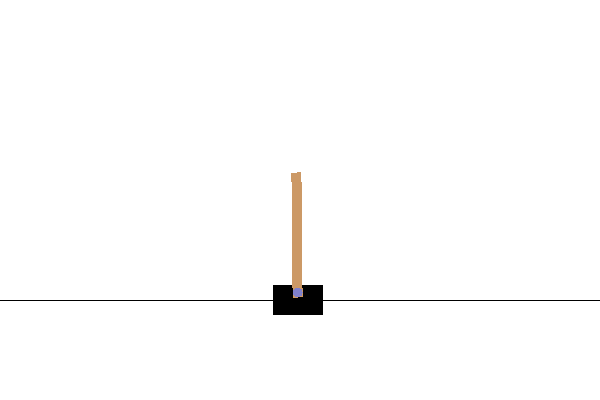

In [8]:
# Environment
#@test {"skip": true}
env = suite_gym.load(env_name)
env.reset()
PIL.Image.fromarray(env.render())

In [9]:

print('Observation Spec:')
print(env.time_step_spec().observation)
print('Action Spec:')
print(env.action_spec())

time_step = env.reset()
print('Time step:')
print(time_step)

action = np.array(1, dtype=np.int32)
next_time_step = env.step(action)
print('Next time step:')
print(next_time_step)

train_py_env = suite_gym.load(env_name)
eval_py_env = suite_gym.load(env_name)

train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)


Observation Spec:
BoundedArraySpec(shape=(4,), dtype=dtype('float32'), name='observation', minimum=[-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], maximum=[4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38])
Action Spec:
BoundedArraySpec(shape=(), dtype=dtype('int64'), name='action', minimum=0, maximum=1)
Time step:
TimeStep(step_type=array(0, dtype=int32), reward=array(0., dtype=float32), discount=array(1., dtype=float32), observation=array([ 0.01535411, -0.02360665, -0.02608814,  0.02171631], dtype=float32))
Next time step:
TimeStep(step_type=array(1, dtype=int32), reward=array(1., dtype=float32), discount=array(1., dtype=float32), observation=array([ 0.01488198,  0.17187953, -0.02565381, -0.2790822 ], dtype=float32))


In [0]:
# Agent

actor_net = actor_distribution_network.ActorDistributionNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    fc_layer_params=fc_layer_params)

optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

train_step_counter = tf.compat.v2.Variable(0)

tf_agent = reinforce_agent.ReinforceAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    actor_network=actor_net,
    optimizer=optimizer,
    normalize_returns=True,
    train_step_counter=train_step_counter)
tf_agent.initialize()


In [0]:
# Policies

eval_policy = tf_agent.policy
collect_policy = tf_agent.collect_policy


In [0]:
# Metrics and Evaluation

def compute_avg_return(environment, policy, num_episodes=10):
  total_return = 0.0
  for _ in range(num_episodes):
    time_step = environment.reset()
    episode_return = 0.0
    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return

  avg_return = total_return / num_eval_episodes
  print(avg_return)
  return avg_return.numpy()[0]


In [0]:
# Replay Buffer

replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=tf_agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_capacity)

In [0]:
# Data Collection

#@test {"skip": true}

def collect_episode(environment, policy, num_episodes):

  episode_counter = 0
  environment.reset()

  while episode_counter < num_episodes:
    time_step = environment.current_time_step()
    action_step = policy.action(time_step)
    next_time_step = environment.step(action_step.action)
    traj = trajectory.from_transition(time_step, action_step, next_time_step)

    # Add trajectory to the replay buffer
    replay_buffer.add_batch(traj)

    if traj.is_boundary():
      episode_counter += 1




In [15]:
# Training the agent

#@test {"skip": true}
try:
  %%time
except:
  pass

# (Optional) Optimize by wrapping some of the code in a graph using TF function.
tf_agent.train = common.function(tf_agent.train)

# Reset the train step
tf_agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, tf_agent.policy, num_eval_episodes)
returns = [avg_return]

for _ in range(num_iterations):

  # Collect a few episodes using collect_policy and save to the replay buffer.
  collect_episode(
      train_env, tf_agent.collect_policy, collect_episodes_per_iteration)

  # Use data from the buffer and update the agent's network.
  experience = replay_buffer.gather_all()
  train_loss = tf_agent.train(experience)
  replay_buffer.clear()

  step = tf_agent.train_step_counter.numpy()

  if step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss.loss))

  if step % eval_interval == 0:
    avg_return = compute_avg_return(eval_env, tf_agent.policy, num_eval_episodes)
    print('step = {0}: Average Return = {1}'.format(step, avg_return))
    returns.append(avg_return)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 5.96 µs
tf.Tensor([8.8], shape=(1,), dtype=float32)
step = 25: loss = -0.07450294494628906
step = 50: loss = 0.09164947271347046
tf.Tensor([46.6], shape=(1,), dtype=float32)
step = 50: Average Return = 46.599998474121094
step = 75: loss = -0.38200947642326355
step = 100: loss = -2.37935209274292
tf.Tensor([81.3], shape=(1,), dtype=float32)
step = 100: Average Return = 81.30000305175781
step = 125: loss = -0.07739245891571045
step = 150: loss = -0.7533381581306458
tf.Tensor([126.5], shape=(1,), dtype=float32)
step = 150: Average Return = 126.5
step = 175: loss = -0.6712571382522583
step = 200: loss = -3.5136494636535645
tf.Tensor([200.], shape=(1,), dtype=float32)
step = 200: Average Return = 200.0
step = 225: loss = -1.660431146621704
step = 250: loss = 1.2360010147094727
tf.Tensor([200.], shape=(1,), dtype=float32)
step = 250: Average Return = 200.0


(-0.7599997997283943, 250)

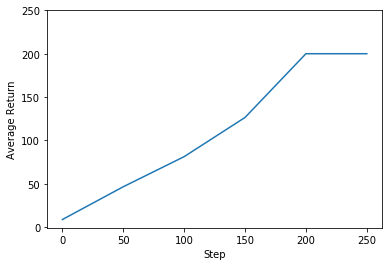

In [16]:
# Visualization - Plots

steps = range(0, num_iterations + 1, eval_interval)
plt.plot(steps, returns)
plt.ylabel('Average Return')
plt.xlabel('Step')
plt.ylim(top=250)



In [0]:
# Visualization - Videos

def embed_mp4(filename):
  video = open(filename, 'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
    <video width="640" height="480" controls>
      <source src="data:video/mp4;base64,{0}" type="video/mp4">
    Your browser does not support the video tag.
    </video>'''.format(b64.decode())
  return IPython.display.HTML(tag)

In [18]:
num_episodes = 3
video_filename = 'imageio.mp4'
with imageio.get_writer(video_filename, fps=60) as video:
  for _ in range(num_episodes):
    time_step = eval_env.reset()
    video.append_data(eval_py_env.render())
    while not time_step.is_last():
      action_step = tf_agent.policy.action(time_step)
      time_step = eval_env.step(action_step.action)
      video.append_data(eval_py_env.render())

embed_mp4(video_filename)
